# Blink Detector
### Recognize whether eye is opened or closed on image

## Set up

In [1]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from sklearn.metrics import confusion_matrix
from keras.constraints import max_norm
from keras.activations import relu
import matplotlib.pyplot as plt
from keras import backend as K
from pylab import rcParams
import tensorflow as tf
import numpy as np
import cv2
import itertools
import keras
%matplotlib inline

Using TensorFlow backend.


## Pre-process frame


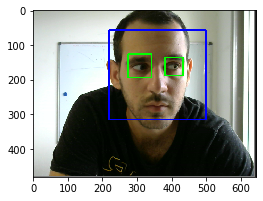

In [2]:
rcParams['figure.figsize'] = 4, 4
face_and_eyes = cv2.imread('face_and_eyes.PNG')
plt.imshow(face_and_eyes[:,:,::-1])

###### crop face

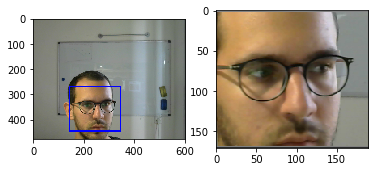

In [3]:
face_rec = cv2.imread('Face_rec.PNG')
crop_face = cv2.imread('Crop_face.PNG')

rcParams['figure.figsize'] = 6, 6
fig, ax = plt.subplots(1,2)
ax[0].imshow(face_rec[:,:,::-1])
ax[1].imshow(crop_face[:,:,::-1])
plt.show()

###### crop eyes

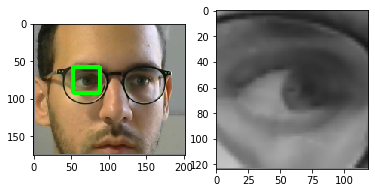

In [4]:
eyes_rec = cv2.imread('eye_rec.PNG')
crop_eyes = cv2.imread('crop_eye.PNG')
fig, ax = plt.subplots(1,2)
ax[0].imshow(eyes_rec[:,:,::-1])
ax[1].imshow(crop_eyes[:,:,::-1])
plt.show()

In [5]:
train_path = 'Data/train'
test_path = 'Data/test'

BATCH_SIZE = 128
TARGET_SIZE = (26, 34)
CLASSES = ['Close', 'Open']

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

## Functions


###### prints and plots confusion matrix

In [6]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes) + 1)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.tight_layout()
    plt.yticks(tick_marks, classes)
    plt.tight_layout()

    print(cm)
    thresh = cm.max() // 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


###### plots images with labels


In [7]:
def plot_data(train):
    for X, y in train:

        plt.figure(figsize=(16, 16))
        for i in range(25):
            plt.subplot(5, 5, i + 1)
            plt.axis('off')
            plt.title('Label: %d' % np.argmax(y[i]))
            img = np.uint8(255 * X[i, :, :, 0])
            plt.imshow(img)
        break

## Pre-process model
● Train set - close eyes: 4,490, open eyes: 4,222 --> total 8712 before validation, and after validation 6970 samples.

● Validation set - Train 0.3 from train set --> total 1742 samples.

● Test set - close eyes: 8, open eyes: 8 --> total 16 samples.


###### Data augmentation

In [8]:
data_augmentation = ImageDataGenerator(rescale=1./255,
                                       rotation_range=10,
                                       width_shift_range=0.1,
                                       brightness_range=[0.2, 0.5],
                                       height_shift_range=0.1,
                                       shear_range=0.3,
                                       fill_mode='nearest',                                                                           
                                       validation_split=0.2)

###### Flow from directory

In [9]:
train = data_augmentation.flow_from_directory(train_path,
                                                target_size=TARGET_SIZE,
                                                color_mode='grayscale',
                                                batch_size=BATCH_SIZE,
                                                classes=CLASSES,
                                                class_mode='categorical',
                                                shuffle=True,
                                                subset='training')

validation = data_augmentation.flow_from_directory(train_path,
                                                   target_size=TARGET_SIZE,
                                                   color_mode='grayscale',
                                                   batch_size=BATCH_SIZE,
                                                   classes=CLASSES,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   subset='validation')


Found 6970 images belonging to 2 classes.
Found 1742 images belonging to 2 classes.


 ###### Make sure our data are labeled correctly 
 0. Close eye
 1. Open eye

[MRL Eye Dataset](http://mrl.cs.vsb.cz/eyedataset)

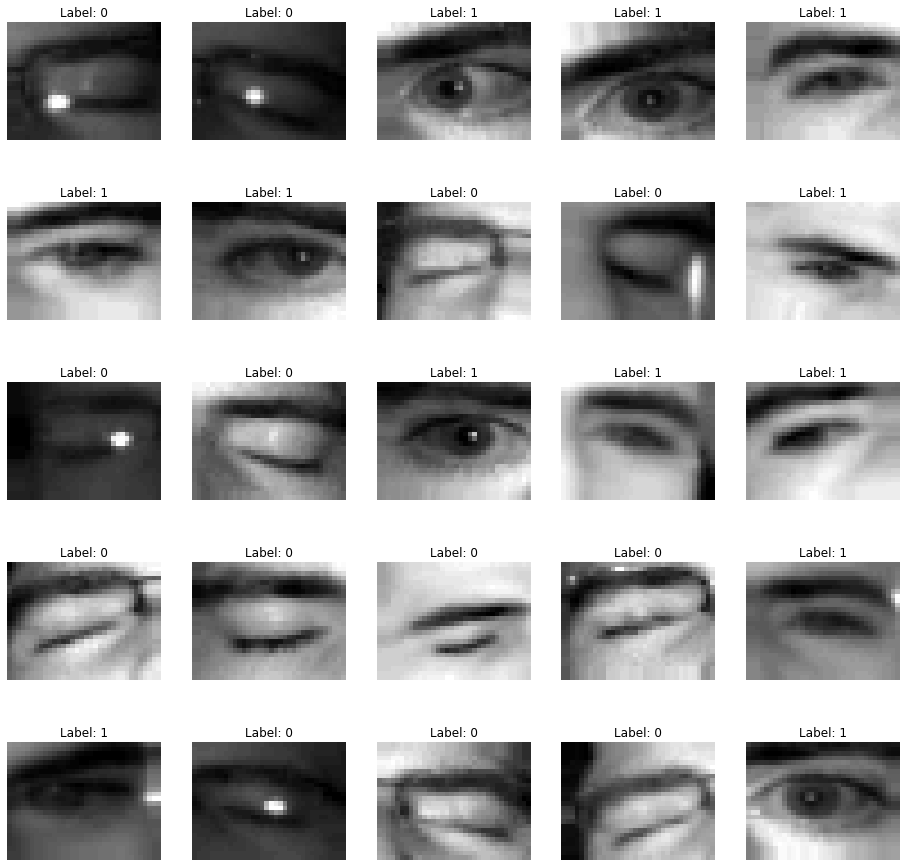

In [10]:
plot_data(train)

## Convolutional Neural Network Architecture


In [11]:
model = Sequential()
model.add(Conv2D(128, (3, 3), input_shape=(26, 34, 1)))
#model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 32, 128)       1280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 14, 64)        73792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 5, 32)          18464     
______________________

###### configures the model for training


In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])


callback_list = [
                EarlyStopping(monitor='val_loss', patience=5, mode='auto'),
                ModelCheckpoint(filepath='Weight/eye_model_notenook.h5', monitor='val_loss', save_best_only=True),
                                
]

## Training


In [13]:
history = model.fit_generator(train,
                    steps_per_epoch=train.samples // BATCH_SIZE,
                    epochs=70,
                    validation_data=validation,
                    validation_steps=validation.samples // BATCH_SIZE,
                    callbacks=callback_list,
                    verbose=2
                    )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/70
 - 22s - loss: 0.4198 - acc: 0.8034 - val_loss: 0.2530 - val_acc: 0.9501
Epoch 2/70
 - 17s - loss: 0.2203 - acc: 0.9220 - val_loss: 0.2338 - val_acc: 0.9591
Epoch 3/70
 - 17s - loss: 0.1633 - acc: 0.9418 - val_loss: 0.1506 - val_acc: 0.9684
Epoch 4/70
 - 17s - loss: 0.1500 - acc: 0.9475 - val_loss: 0.1675 - val_acc: 0.9678
Epoch 5/70
 - 31s - loss: 0.1360 - acc: 0.9506 - val_loss: 0.1328 - val_acc: 0.9696
Epoch 6/70
 - 23s - loss: 0.1276 - acc: 0.9525 - val_loss: 0.1386 - val_acc: 0.9647
Epoch 7/70
 - 18s - loss: 0.1138 - acc: 0.9592 - val_loss: 0.1147 - val_acc: 0.9727
Epoch 8/70
 - 17s - loss: 0.1047 - acc: 0.9642 - val_loss: 0.1158 - val_acc: 0.9765
Epoch 9/70
 - 17s - loss: 0.1037 - acc: 0.9630 - val_loss: 0.1006 - val_acc: 0.9752
Epoch 10/70
 - 17s - loss: 0.0895 - acc: 0.9674 - val_loss: 0.0864 - val_acc: 0.9802
Epoch 11/70
 - 16s - loss: 0.0868 - acc: 0.9699 - val_loss: 0.111

## Performance and Analysis

Text(0.5, 0, '# of epochs')

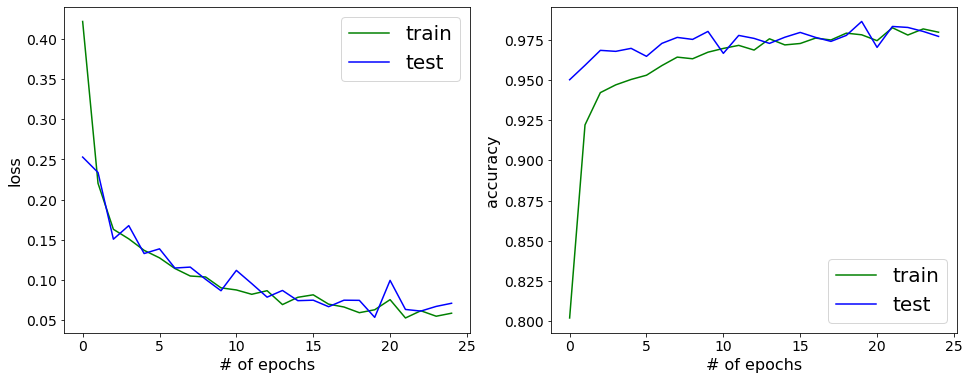

In [14]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
nepochs=len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'], 'g-', label='train')
plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('loss')
plt.xlabel('# of epochs')
plt.subplot(1,2,2)
plt.plot(range(nepochs), history.history['acc'],     'g-', label='train')
plt.plot(range(nepochs), history.history['val_acc'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('accuracy')
plt.xlabel('# of epochs')

###### Data augmentation and flow from directory for test set

In [15]:
test_data_augmentation = ImageDataGenerator(rescale=1./255)
test = test_data_augmentation.flow_from_directory(
        test_path,
        target_size=TARGET_SIZE,
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        classes=CLASSES,
        class_mode='categorical',
        shuffle=False
    )

Found 16 images belonging to 2 classes.


###### Testing accuracy

In [16]:
X_test, y_test = [], []
for i, (X, y) in enumerate(test):
    X_test.append(X)
    y_test.append(y)
    i += 1
    if (i == 50): break
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)
y_test = np.int32([np.argmax(r) for r in y_test])
y_pred = np.int32([np.argmax(r) for r in model.predict(X_test)])
match = (y_test == y_pred)
print('Testing Accuracy = %.2f%%' % (np.sum(match)*100/match.shape[0]))

Testing Accuracy = 93.75%


###### Confusion matrix

[[350  50]
 [  0 400]]


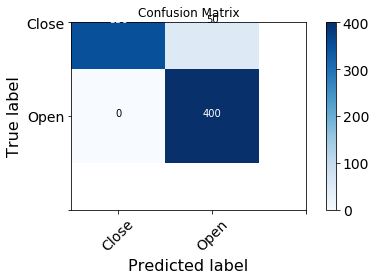

In [14]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, CLASSES, title='Confusion Matrix')